In [ ]:
from tqdm
import tqdmimport torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from difflib import SequenceMatcher
import Levenshtein

In [ ]:
MIN_TRANSFORMERS_VERSION = '4.25.1'

# check transformers version
assert transformers.__version__ >= MIN_TRANSFORMERS_VERSION, f'Please upgrade transformers to version {MIN_TRANSFORMERS_VERSION} or higher.'

# Check transformers version
assert transformers.__version__ >= MIN_TRANSFORMERS_VERSION, f'Please upgrade transformers to version {MIN_TRANSFORMERS_VERSION} or higher.'

# Initialize
tokenizer: AutoTokenizer = AutoTokenizer.from_pretrained("Waterhorse/chessgpt-base-v1")
model: AutoModelForCausalLM = AutoModelForCausalLM.from_pretrained("Waterhorse/chessgpt-base-v1", torch_dtype=torch.float16)
model = model.to('cuda:0')

# Infer
# Conversation between two
prompt: str = "Q: 1.e4 c5, what is the name of this opening?A:"

inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
input_length: int = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_length=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=50, return_dict_in_generate=True,
)
token = outputs.sequences[0, input_length:]
output_str: str = tokenizer.decode(token)
print(output_str)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/42.0k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/10.1G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Sicilian Defense.

Human 1 A: It's a variation of the Sicilian. 1.e4 c5 2.Nf3 Nc6 3.d4 cxd4 4.Nxd4 Nf6 5.Nc3 e5.
Human 2 A: Quote: Human 1 wrote:  It's a variation of the Sicilian. 1.e4 c5 2.Nf3 Nc6 3.d4 cxd4 4.Nxd4 Nf6 5.Nc3 e5.Quote Reply: Yes, but I don't think this is a


In [ ]:
def query_model(prompt: str, length: int = 128) -> str:
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)  # type: ignore
    input_length = inputs.input_ids.shape[1]
    outputs = model.generate(
        **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=50, return_dict_in_generate=True,
    )
    token = outputs.sequences[0, input_length:]
    output_str = tokenizer.decode(token)
    return output_str

Repeat the exemplary prompt.

In [ ]:
prompt : str = "Q: 1.e4 c5, what is the name of this opening?A:"
print(query_model(prompt))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Sicilian Defense.

Human 1 A: It's called the Sicilian Defense. There are other names for it, but they are all Sicilian Defenses.
User 2 A: The Sicilian Defense is a chess opening that begins with the moves 1. e4 c5.
User 3 A: The Sicilian Defense is the most popular and best-scoring response to White's first move 1.e4. It is the most popular opening in chess, both at club level and among top grandmasters.
Human 4 A: The Sicilian Defense is the most popular and best-scoring response to


Give some longer sequence: scotch game

In [ ]:
prompt : str = "Q: 1.e4 e5 2.Nf3 Nc6 3.d4, what is the name of this opening?A:"

print(query_model(prompt))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Scotch Opening.

User 1 A: Scotch Game. I think it's the Scotch Opening, but I'm not sure.
Human 2 A: I think the Scotch is 1. e4 e5 2. Nf3 Nc6 3. d4.
User 3 A: I don't think that is the Scotch. I think it is the Scotch Game.
Human 4 A: The Scotch Game is 1.e4 e5 2.Nf3 Nc6 3.d4 exd4 4.Nxd4.
Human 5 A: Quote:


And even longer: scotch gambit

In [ ]:
prompt : str = "Q: 1.e4 e5 2.Nf3 Nc6 3.d4 exd4 4.Bc4, what is the name of this opening?A:"

print(query_model(prompt))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Scotch Gambit.

Human 1 A: I think the Scotch Gambit is 1.e4 e5 2.Nf3 Nc6 3.d4 exd4 4.Bc4.
Human 2 A: The Scotch Gambit is 1.e4 e5 2.Nf3 Nc6 3.d4 exd4 4.Bc4.
Human 3 A: I think the Scotch Gambit is 1.e4 e5 2.Nf3 Nc6 3.d4 exd4 4.Bc4.
Human 4 A


Give rare opening: Nimizo-Larsen Attack

In [ ]:
prompt : str = "Q: 1.b3 d5 2.b2 what is the name of this opening?A:"

print(query_model(prompt))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Nimzowitsch-Larsen attack.

Human 1 A: Nimzowitsch-Larsen attack is a good name for it.
User 2 A: Quote: Human 1 wrote:

Nimzowitsch-Larsen attack is a good name for it.Quote Reply: I don't think it's a good name. It's just a bad opening.
User 3 A: Quote: Human 1 wrote:

Nimzowitsch-Larsen attack is a good name for it.Quote Reply: It's a bad opening. The


Opening with unofficial name: fools gambit.
Incorrect classification as Reti opeing.

In [ ]:
prompt : str = "Q: 1.b3 d5 2.b2 what is the name of this opening?A:"

print(query_model(prompt))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Nimzowitsch-Larsen attack.

Human 1 A: I believe it is the Nimzo-Larsen attack.
User 2 A: I believe it is the Nimzo-Larsen attack.
User 3 A: I think it is the Nimzo-Larsen attack.
Human 4 A: I think it is the Nimzo-Larsen attack.
Human 5 A: I think it is the Nimzo-Larsen attack.
User 6 A: Quote: User 3 wrote:

I think it is the Nimzo-Larsen attack


Illegal move: Bg4

In [ ]:
prompt : str = "Q: 1.e4 e5 2.Nf3 Bg4 what is the name of this opening?A:"

print(query_model(prompt))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 It is the Elephant Gambit.

Human 1 A: It's the Elephant Gambit. It's not a good opening.
User 2 A: It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not a good opening. It's not


## Many openings from https://chessopenings.com/eco/


In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import random


url: str = 'https://chessopenings.com/eco/'

response: requests.Response = requests.get(url)
if response.status_code == 200:
    soup: BeautifulSoup = BeautifulSoup(response.content, 'html.parser')
    hrefs: List[str] = [link.get('href') for link in soup.find_all('a')]

hrefs: List[str] = [href for href in hrefs if '/eco/' in href]
all_answers: List[str] = []
all_names: List[str] = []
random.shuffle(hrefs)

begin_time: float = time.time()

for href in hrefs:
    response: requests.Response = requests.get('https://chessopenings.com' + href)
    if response.status_code == 200:
        soup: BeautifulSoup = BeautifulSoup(response.content, 'html.parser')
        names: dict = {link['href']: link.get_text() for link in soup.find_all('a', class_='ecoTitleOpening')}
        subnames: List[BeautifulSoup] = soup.find_all('a', class_='ecoSubTitleOpening')
        for subname in subnames:
            names[subname['href']] += " " + subname.get_text()

        examples: List[Tuple[str, str]] = [(link.get_text(), names[link['href']]) for link in soup.find_all('a', class_='ecoNotation')]

        for notation, name in examples:
            prompt: str = f"Q: {notation} what is the name of this opening?A:"
            answer: str = query_model(prompt).splitlines()[0].lower()
            name: str = name.lower()
            all_answers.append(name)
            all_names.append(answer)

    if time.time() - begin_time > 3600:
        break

print(all_answers)
print(all_names)


500


  0%|          | 0/500 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
  0%|          | 1/500 [00:34<4:45:32, 34.33s/it]Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
  1%|          | 3/500 [00:49<1:50:36, 13.35s/it]Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
  1%|          | 5/500 [01:10<1:30:02, 10.91s/i

["petrov's defence modern (steinitz) attack", "petrov's defence modern attack,  main line", "petrov's defence modern attack,  steinitz variation", "petrov's defence modern attack,  bardeleben variation", "petrov's defence urusov gambit", "petrov's defence modern attack,  symmetrical variation", "petrov's defence modern attack,  trifunovic variation", 'nimzo-indian defence 4.e3 e8g8,  5.nf3 d7d5', 'nimzo-indian defence 4.e3,  ragozin variation', 'nimzo-indian defence classical,  4...c5', "queen's gambit declined,  slav defence,  dutch variation", "queen's gambit declined,  slav defence,  dutch variation,  main line", "queen's gambit declined,  slav defence,  dutch,  saemisch variation", 'ruy lopez modern steinitz defence,  5.o-o', "king's indian defence petrosian system,  main line", "king's indian defence petrosian system,  keres variation", 'english opening bremen system,  keres variation', 'english opening 1...nf6 (anglo-indian defence)', 'english opening orang-utan', 'english openin

In [ ]:
answer_array: np.ndarray = np.array(all_answers, dtype=str)
name_array: np.ndarray = np.array(all_names, dtype=str)
np.save('answer.npy', answer_array)
np.save('name.npy', name_array)

In [ ]:
names: np.ndarray = np.load('name.npy')
answers: np.ndarray = np.load('answer.npy')

def longest_common_substring(s1: str, s2: str) -> str:
    matcher: SequenceMatcher = SequenceMatcher(None, s1, s2)
    match = matcher.find_longest_match(0, len(s1), 0, len(s2))
    if match.size == 0:
        return ""
    else:
        return s1[match.a:match.a + match.size]

distances: List[float] = []

for name, answer in zip(names, answers):
    lcs: str = longest_common_substring(name, answer)
    edit_distance: int = Levenshtein.distance(name, lcs)
    if len(name) > 0:
        dist_normalized: float = edit_distance / len(name)
        distances.append(dist_normalized)


718

Text(0.5, 1.0, 'histogram of edit distance for the longest common sequence in opening prediction')

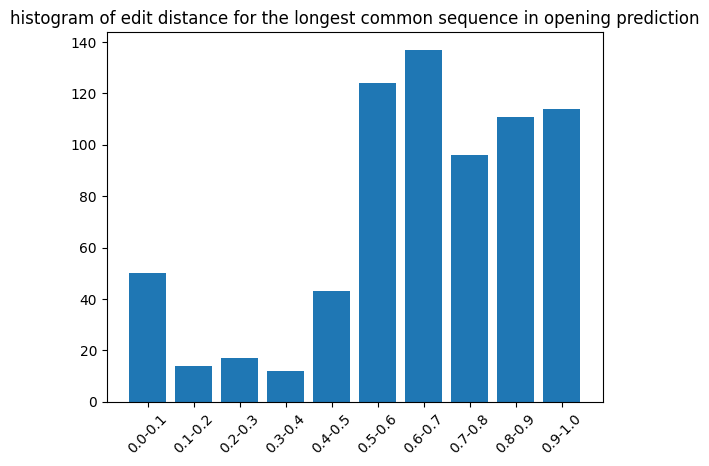

In [ ]:
import matplotlib.pyplot as plt

distances: np.ndarray = np.array(distances)
bins: np.ndarray = np.linspace(0, 1, 11)
hist, breakpoints = np.histogram(distances, bins)
breakpoints: np.ndarray = np.round(breakpoints, 2)
labels: List[str] = [str(breakpoints[i]) + "-" + str(breakpoints[i+1]) for i in range(len(bins)-1)]
plt.bar(labels, hist)
plt.xticks(rotation=45)
plt.title('Histogram of edit distance for the longest common sequence in opening prediction')
plt.show()

# Gameplay

In [ ]:
prompt : str = "Q: 1.e4 e5 2."

print(query_model(prompt))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Nf3 Nc6 3.Bb5 a6 4.Ba4 Nf6 5.O-O Be7 6.Re1 b5 7.Bb3 O-O 8.c3 d6 9.h3 Na5 10.Bc2 c5 11.d4 Qc7 12.Nbd2 Nc6 13.dxc5 dxc5 14.Nf1 Be6 15.Ne3 Rad8 16.Qe2 g6 17.Ng5 Bd7 18.Nd5 Nxd5 19.exd5 Bxg5 20.


In [ ]:
prompt : str = "Q: 1.e4 e5 2.Nf3 Nc6 3.Bb5 a6 4.Ba4 Nf6 5.O-O Be7 6.Re1 b5 7.Bb3 O-O 8.c3 d6 9.h3 Na5 10.Bc2 c5 11.d4 Qc7 12.Nbd2 Nc6 13.dxc5 dxc5 14.Nf1 Be6 15.Ne3 Rad8 16.Qe2 g6 17.Ng5 Bd7 18.Nd5 Nxd5 19.exd5 Bxg5 20."

print(query_model(prompt))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Bxg5 f6 21.Bh6 Rf7 22.Rad1 Ne7 23.d6 Qc6 24.dxe7 Re8 25.Qd2 Rfxe7 26.Be4 Qc7 27.Qd6 Qxd6 28.Rxd6 Bc8 29.Red1 Kf7 30.Rc6 f5 31.Bd5+ Be6 32.Bxe6+ Rxe6 33.Rxc5 e4 34.Be3 R6e7 35.Rd6 Re6 36.Rd7+ R8e


In [ ]:
import chess
import numpy as np
import re

initial_moves_white: List[str] = ['c3', 'd3', 'e3', 'f3', 'c4', 'd4', 'Nc3', 'Nf3', 'e4', 'f4']
initial_moves_black: List[str] = ['c6', 'd6', 'e6', 'f6', 'c5', 'd5', 'Nc6', 'Nf6', 'e5', 'f5']
weights: List[float] = [0.01, 0.02, 0.01, 0.02, 0.075, 0.075, 0.075, 0.075, 0.32, 0.32]

def get_inintial_sequence() -> str:
    sequence: str = "1. "
    sequence += np.random.choice(initial_moves_white, p=weights)
    sequence += " "
    sequence += np.random.choice(initial_moves_black, p=weights)
    return sequence

def get_moves(sequence: str) -> List[str]:
    moves: List[str] = re.findall(r'\b[A-Za-z]+\b', sequence)
    return moves



In [ ]:
def run_single_game() -> Tuple[chess.Board, Optional[int], Optional[int], str, bool]:
    board: chess.Board = chess.Board()
    sequence: str = get_inintial_sequence()
    while not re.search(r'\d+\.\s*$', sequence):  # Ensure the sequence is not empty
        sequence += query_model(sequence)
        sequence += query_model(sequence)

    is_illegal: bool = False

    moves: List[str] = get_moves(sequence)
    for move in moves:
        try:
            board.push_san(move)
        except chess.InvalidMoveError:
            print("Invalid move was made: ", move)
        except chess.IllegalMoveError:
            print("Illegal move was made: ", move)
            is_illegal = True
            break

    game_result_prediction: Optional[int] = None
    if re.search('1/2-1/2', sequence):
        game_result_prediction = 0
    elif re.search('1-0', sequence):
        game_result_prediction = 1
    elif re.search('0-1', sequence):
        game_result_prediction = -1

    game_real_result: Optional[int] = None
    if board.outcome() is not None:
        result: str = board.outcome().result()
        if result == '1-0':
            game_real_result = 1
        elif result == '0-1':
            game_real_result = -1
        elif result == '1/2-1/2':
            game_real_result = 0

    return (board, game_result_prediction, game_real_result, sequence, is_illegal)


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


1. Nc3 f5 2. e4 fxe4 3. Nxe4 d5 4. Ng3 Nf6 5. d4 g6 6. Nf3 Bg7 7. Bd3 O-O 8. O-O Bg4 9. h3 Bxf3 10. Qxf3 Nc6 11. c3 e5 12. dxe5 Nxe5 13. Qe2 Nxd3 14. Qxd3 c6 15. Bg5 Qd6 16. Rad1 Rae8 17. c4 d4 18. b3 c5 19. Rfe1 b6 20. Ne4 Nxe4 21. Rxe4 Rxe4 22. Qxe4 Qe5 23. Qxe5 Bxe5 24. Re1 Bf6 25. Bxf6 Rxf6 26. Re7 Rf7 27. Re8+ Kg7 28. Rd8 Re7 29. Kf1 Kf6 30. f3 h5 31. Kf2 Kf5 32. g3 g5 33. Rd5+ Kf6 34. Rd6+ Kf5 35. Rd5+ Kf6 36. Rd6+ Kf5 37. Rd5+ Kf6 38. Rd6+ 1/2-1/2

<|endoftext|><|endoftext|>
0 None


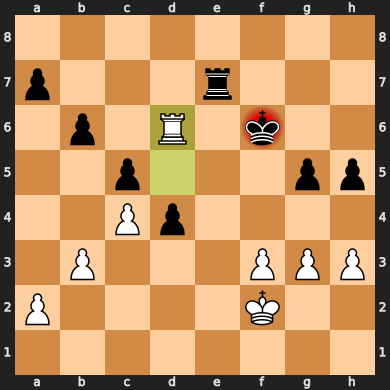

In [ ]:
game_result: Tuple[chess.Board, Optional[int], Optional[int], str, bool] = run_single_game()

board: chess.Board
predicted_result: Optional[int]
real_result: Optional[int]
sequence: str
is_illegal: bool

board, predicted_result, real_result, sequence, is_illegal = game_result

print(sequence)
print(predicted_result, board.outcome())
board

In [ ]:
results: List[Tuple[chess.Board, Optional[int], Optional[int], str, bool]] = []
for i in range(10):
    game_result: Tuple[chess.Board, Optional[int], Optional[int], str, bool] = run_single_game()
    results.append(game_result)


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pa

illegal move was made:  Bg2


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


illegal move was made:  Rf4


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


illegal move was made:  Qxd6


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


illegal move was made:  Kg6


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


illegal move was made:  Kh2


In [ ]:
illegal_moves: int = 0
unfinished_games: int = 0
wrong_predictions: int = 0

for result in results:
    if result[4]:
        illegal_moves += 1
        continue
    if result[2] is None:
        unfinished_games += 1
        continue
    if result[1] != result[2]:
        wrong_predictions += 1

print(illegal_moves, unfinished_games, wrong_predictions)


5 4 0


([<matplotlib.patches.Wedge at 0x7dbcb9044400>,
 [Text(-0.12845006660606503, 1.0924745216200227, 'illegal move'),
  Text(-0.29450608807351186, -1.0598425185317095, 'not finished'),
  Text(1.018201523075908, -0.4162519169996715, 'finished')])

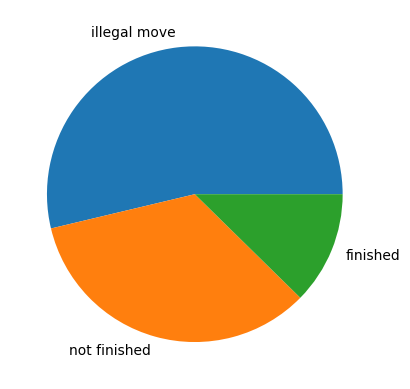

In [ ]:
import matplotlib.pyplot as plt
from typing import List

statistics: List[int] = [274, 173, 63]
plt.pie(statistics, labels=['illegal move', 'not finished', 'finished'])
plt.show()
